## Imports

In [1]:
%env CUDA_VISIBLE_DEVICES=0
%matplotlib inline

env: CUDA_VISIBLE_DEVICES=0


In [2]:
import os                                                                       
import numpy as np                                                              
import matplotlib.pyplot as plt
import scipy
import tensorflow as tf                                                         
import data.data_selector as ds                                                   
import analysis.analysis_picker as ap
import utils.plot_functions as pf                                               

## Model parameters

In [3]:
analysis_params = {
  "model_type": "subspace_lca",
  "model_name": "subspace_lca",
  "version": "0.0",
  "save_info": "analysis"}

# Computed params
analysis_params["model_dir"] = (os.path.expanduser("~")+"/Work/Projects/"
  +analysis_params["model_name"])

## Load analyzer

In [4]:
analyzer = ap.get_analyzer(analysis_params)
analyzer.model.setup(analyzer.model_params, analyzer.model_schedule)
analyzer.load_analysis(save_info=analysis_params["save_info"])

#ot_bf_indices = analyzer.ot_grating_responses["neuron_indices"]
#ot_contrasts = analyzer.ot_grating_responses["contrasts"]
#ot_phases = analyzer.ot_grating_responses["phases"]
#ot_orientations = analyzer.ot_grating_responses["orientations"]
#ot_best_phases = analyzer.ot_grating_responses["best_phases"]
#ot_mean_activations = analyzer.ot_grating_responses["mean_responses"]
#
#co_bf_indices = analyzer.co_grating_responses["neuron_indices"]
#co_contrasts = analyzer.co_grating_responses["contrasts"]
#co_phases = analyzer.co_grating_responses["phases"]
#co_base_orientations = analyzer.co_grating_responses["base_orientations"]
#co_mask_orientations = analyzer.co_grating_responses["mask_orientations"]
#co_base_mean_responses = analyzer.co_grating_responses["base_mean_responses"]
#co_test_mean_responses = analyzer.co_grating_responses["test_mean_responses"]

### New Analysis

In [5]:
data = ds.get_data(analyzer.model_params)
data = analyzer.model.preprocess_dataset(data, analyzer.model_params)
data = analyzer.model.reshape_dataset(data, analyzer.model_params)

In [6]:
num_imgs = 10000#data["train"].images.shape[0]
config = tf.ConfigProto()
config.gpu_options.allow_growth = True
with tf.Session(config=config, graph=analyzer.model.graph) as sess:
  feed_dict = analyzer.model.get_feed_dict(data["train"].images[0:num_imgs,...])
  sess.run(analyzer.model.init_op, feed_dict)
  analyzer.model.load_weights(sess, analyzer.cp_loc)
  run_list = [analyzer.model.a, analyzer.model.group_activity, analyzer.model.group_angles]
  neuron_activations, group_activations, group_angles = sess.run(run_list, feed_dict)

INFO:tensorflow:Restoring parameters from /home/dpaiton/Work/Projects/subspace_lca/checkpoints/subspace_lca_v0.0_weights-100000


### MNIST

In [ ]:
labels = np.array([np.nonzero(data["train"].labels[label_index,:])[0].item()
  for label_index in range(data["train"].labels.shape[0])]).T

In [2]:
# rank groupings by label category
# grab input samples where labels match a category
# sort activations of groups for those samples with the most active first
# compute mode of top groups
# repeat, excluding previous mode

#np.argwhere(labels==0)

get_mode = lambda x : scipy.stats.mode(x)[0].item()

# Need to exclude groups that were never active for this label

#include_indices = np.arange(analyzer.model.num_groups, dtype=int) # startout looking across all groups
#modes = []
#for neuron_index in range(analyzer.model.num_groups):
#  mode = get_mode([np.argsort(np.squeeze(group_activations)[batch_index, include_indices])[-1]
#    for batch_index in np.argwhere(labels==0)])
#  modes.append(mode)
#  print(include_indices.size)
#  include_indices = include_indices[include_indices!=mode]
#print(modes)

#get_mode([sorted_activations(group_activations[batch_index, include_indices])[0]
#  for batch_index in np.argwhere(labels==0)])
[np.argsort(np.squeeze(group_activations[batch_index,:]))[::-1]
  for batch_index in np.argwhere(labels==0)]

NameError: name 'np' is not defined

### VanHateren

In [7]:
cent_group_activations = np.zeros_like(group_activations)
for group_id in range(analyzer.model.num_groups):
  cent_group_activations[:,group_id] = group_activations[:,group_id] - np.mean(group_activations[:,group_id])

In [8]:
#cov = 1/num_imgs * np.dot(group_activations.T, group_activations)
cov = 1/num_imgs * np.dot(np.squeeze(cent_group_activations).T, np.squeeze(cent_group_activations))
np.fill_diagonal(cov, 0.0)

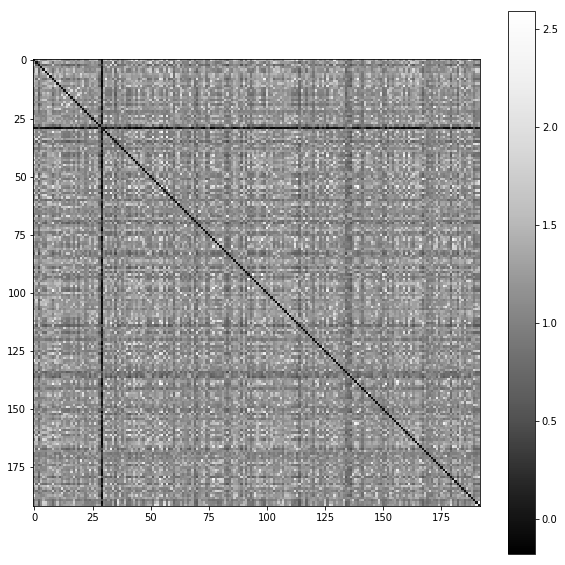

In [9]:
fig = plt.figure(figsize=(10, 10))
plt.imshow(cov, cmap="Greys_r")
plt.colorbar()
plt.show()

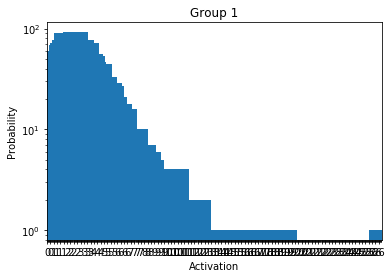

In [10]:
from matplotlib.ticker import FormatStrFormatter
group_idx = 1
num_bins = 1000
figsize = None
indiv_group_act = group_activations[:, group_idx]
bins = np.linspace(np.min(indiv_group_act), np.max(indiv_group_act), num_bins)
hist, bin_edges = np.histogram(indiv_group_act.flatten(), bins)
bin_left, bin_right = bin_edges[:-1], bin_edges[1:]
bin_centers = bin_left + (bin_right - bin_left)/2
fig, ax = plt.subplots(1, figsize=figsize)
ax.bar(bin_centers, hist, width=2.0, log=True, align="center")
ax.set_xticks(bin_left, minor=True)
ax.set_xticks(bin_left[::10], minor=False)
ax.xaxis.set_major_formatter(FormatStrFormatter("%0.0f"))
ax.set_xlim([np.min(indiv_group_act), np.max(indiv_group_act)])
ax.set_title("Group "+str(group_idx))
ax.set_xlabel("Activation")
ax.set_ylabel("Probability")
plt.show()

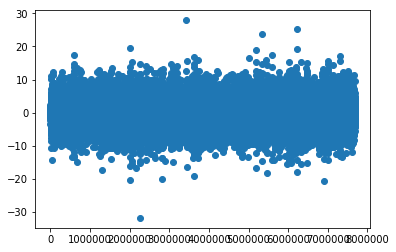

In [11]:
plt.scatter(np.arange(neuron_activations.size), neuron_activations.flatten())
plt.show()

In [12]:
np.count_nonzero(neuron_activations.flatten())/neuron_activations.size

0.1318671875

In [14]:
print(np.min(group_angles), np.mean(group_angles), np.max(group_angles))

-0.9999978 -0.00062445767 0.9999934


In [ ]:
weights = analyzer.evals["weights/phi:0"]
active_idx = np.random.choice(analyzer.model.num_groups)
group_activity_vector = np.zeros((1, analyzer.model.num_groups))
group_activity_vector[0, active_idx] = 1
group_direction = 

## Construct analysis plots

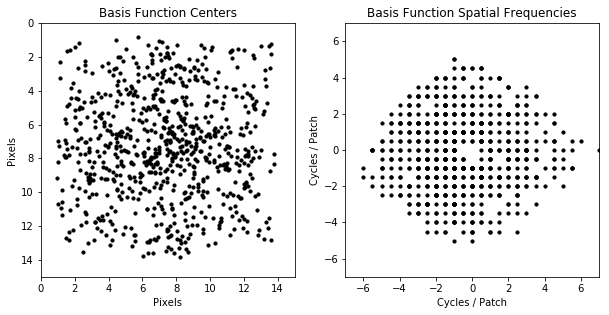

In [10]:
fig = pf.plot_loc_freq_summary(analyzer.bf_stats)
fig.savefig(analyzer.analysis_out_dir+"vis/location_frequency_centers.png")

In [ ]:
neuron_angles = analyzer.neuron_angles(analyzer.bf_stats) * (180/np.pi)

In [ ]:
angle_hist_fig = pf.plot_weight_angle_histogram(neuron_angles, num_bins=50, angle_min=0, angle_max=180, figsize=(8,8))
angle_hist_fig.savefig(analyzer.analysis_out_dir+"/vis/neuron_angle_histogram.png")

In [ ]:
weight_indices = np.stack([np.array(id_list) for id_list in analyzer.model.group_ids], axis=0)
pooling_weights = np.stack([analyzer.evals["weights/phi:0"][:, id_list] for id_list in analyzer.model.group_ids], axis=1)

In [ ]:
pooling_filter_id = 135#28
input_id0 = 0
input_id1 = 2
bf_id0 = 331#weight_indices[pooling_filter_id, input_id0]
bf_id1 = 645#weight_indices[pooling_filter_id, input_id1]
print("BF indices = [",bf_id0,", ",bf_id1,"]")
fig, ax = plt.subplots(2)
ax[0] = pf.clear_axis(ax[0])
ax[0].imshow(analyzer.bf_stats["basis_functions"][bf_id0], cmap="Greys_r")
ax[0].set_title(str(bf_id0))
ax[1] = pf.clear_axis(ax[1])
ax[1].imshow(analyzer.bf_stats["basis_functions"][bf_id1], cmap="Greys_r")
ax[1].set_title(str(bf_id1))
plt.show()
print("vector angle\t= ", neuron_angles[bf_id0, bf_id1], " rad\n\t\t= ", neuron_angles[bf_id0, bf_id1]*(180/np.pi), " deg")
bf1 = analyzer.bf_stats["basis_functions"][bf_id0].reshape((analyzer.model_params["patch_edge_size"]**2))
bf2 = analyzer.bf_stats["basis_functions"][bf_id1].reshape((analyzer.model_params["patch_edge_size"]**2))
bf1_norm = np.linalg.norm(bf1)
bf2_norm = np.linalg.norm(bf2)
print("bf1 norm = ", bf1_norm)
print("bf2 norm = ", bf2_norm)
bf1 /= bf1_norm
bf2 /= bf2_norm

In [ ]:
import utils.data_processing as dp
from data.dataset import Dataset
num_imgs = 10000

x_pts = np.linspace(-2.0, 2.0, int(np.sqrt(num_imgs)))
y_pts = np.linspace(-2.0, 2.0, int(np.sqrt(num_imgs)))
X, Y = np.meshgrid(x_pts, y_pts)
proj_datapoints = np.stack([X.reshape(num_imgs), Y.reshape(num_imgs)], axis=1)

proj_matrix, v = analyzer.bf_projections(bf1, bf2)
proj_neuron1 = np.dot(proj_matrix, bf1).T
proj_neuron2 = np.dot(proj_matrix, bf2).T
proj_v = np.dot(proj_matrix, v).T

datapoints = np.stack([np.dot(proj_matrix.T, proj_datapoints[data_id,:]) for data_id in range(num_imgs)]) #inject
datapoints, orig_shape = dp.reshape_data(datapoints, flatten=False)[:2]
datapoints = {"test": Dataset(datapoints, lbls=None, ignore_lbls=None, rand_state=analyzer.rand_state)}
datapoints = analyzer.model.preprocess_dataset(datapoints,
  params={"whiten_data":analyzer.model_params["whiten_data"],
  "whiten_method":analyzer.model_params["whiten_method"]})
datapoints = analyzer.model.reshape_dataset(datapoints, analyzer.model_params)
datapoints["test"].images /= np.max(np.abs(datapoints["test"].images))
datapoints["test"].images *= analyzer.analysis_params["input_scale"]

In [ ]:
activations = analyzer.compute_pooled_activations(datapoints["test"].images)
activity_max = np.amax(np.abs(activations))
norm_activity = activations / (activity_max+0.0001)

In [ ]:
import matplotlib.gridspec as gridspec
#def plot_iso_response_contours(cmap, save_filename)
num_plots_y = 1
num_plots_x = 2
gs1 = gridspec.GridSpec(num_plots_y, num_plots_x, wspace=0.5, width_ratios=[4, 1])
fig = plt.figure(figsize=(6, 6))
curve_ax = pf.clear_axis(fig.add_subplot(gs1[0]))
#cmap = plt.get_cmap('tab20b')
cmap = plt.get_cmap('viridis')
#cmap = plt.get_cmap('jet')
vmin = np.floor(np.min(norm_activity))#0.0
vmax = np.ceil(np.max(norm_activity))#1.0
rank_indices = np.argsort(norm_activity[:, pooling_filter_id])

pts = curve_ax.scatter(proj_datapoints[:,0][rank_indices], proj_datapoints[:,1][rank_indices],
  vmin=vmin, vmax=vmax, cmap=cmap, c=norm_activity[:, pooling_filter_id][rank_indices], s=5.0)
curve_ax.arrow(0, 0, proj_neuron1[0].item(), proj_neuron1[1].item(), width=0.05, head_width=0.15,
  head_length=0.15, fc='b', ec='b')
curve_ax.arrow(0, 0, proj_neuron2[0].item(), proj_neuron2[1].item(), width=0.05, head_width=0.15,
  head_length=0.15, fc='k', ec='k')
#curve_ax.set_title("Angle = "+"{:.2f}".format(neuron_angles[bf_id0, bf_id1])+" deg")
curve_ax.set_title("Response from pooling neuron "+"{:.0f}".format(pooling_filter_id))
curve_ax.set_ylim([-2, 2.0])
curve_ax.set_xlim([-2, 2.0])
curve_ax.set_aspect("equal")
cbar = pf.add_colorbar_to_im(pts, aspect=20, pad_fraction=0.5, labelsize=16, ticks=[vmin, vmax])
cbar.ax.set_yticklabels(["{:.0f}".format(vmin), "{:.0f}".format(vmax)])

gs2 = gridspec.GridSpecFromSubplotSpec(2, 1, gs1[1], wspace=2, hspace=-0.2)
bf1_ax = pf.clear_axis(fig.add_subplot(gs2[0]))
bf1_ax.imshow(analyzer.bf_stats["basis_functions"][bf_id0], cmap="Greys_r")
bf1_ax.set_title("Input\nNeuron {:.0f}".format(bf_id0), color='b')
bf2_ax = pf.clear_axis(fig.add_subplot(gs2[1]))
bf2_ax.imshow(analyzer.bf_stats["basis_functions"][bf_id1], cmap="Greys_r")
bf2_ax.set_title("Input\nNeuron {:.0f}".format(bf_id1), color='k')
fig.savefig(analyzer.analysis_out_dir+"/vis/l2_neuron_response_contours_pid"+str(pooling_filter_id)+"_bf0id"+str(bf_id0)+"_bf1id"+str(bf_id1)+".png")
plt.show()

In [ ]:
x_target = x_pts[int(6*np.sqrt(num_imgs)/8)] # find a location to take a slice
slice_indices = np.where(proj_datapoints[:,0]==x_target)[0]
x_vals = proj_datapoints[slice_indices,:][:,1] # slice grid

In [ ]:
pop_num_imgs = 100

orthogonal_list = [idx for idx in range(analyzer.bf_stats["num_outputs"]) if idx != bf_id0]#[bf_id1]
num_orthogonal = len(orthogonal_list)

pop_x_pts = np.linspace(-2.0, 2.0, int(pop_num_imgs))
pop_y_pts = np.linspace(-2.0, 2.0, int(pop_num_imgs))
pop_X, pop_Y = np.meshgrid(pop_x_pts, pop_y_pts)
pop_proj_datapoints = np.stack([pop_X.reshape(pop_num_imgs**2), pop_Y.reshape(pop_num_imgs**2)], axis=1) # construct a grid
x_target = pop_x_pts[int(6*pop_num_imgs/8)] # find a location to take a slice
slice_indices = np.where(pop_proj_datapoints[:,0]==x_target)[0]
pop_proj_datapoints = pop_proj_datapoints[slice_indices,:] # slice grid

pop_datapoints = [None,]*num_orthogonal
pop_proj_neurons = [None,]*num_orthogonal
for pop_idx, tmp_bf_id1 in enumerate(orthogonal_list):
  tmp_bf2 = analyzer.bf_stats["basis_functions"][tmp_bf_id1].reshape((analyzer.model_params["patch_edge_size"]**2))
  tmp_bf2 /= np.linalg.norm(tmp_bf2)
  tmp_proj_matrix, tmp_proj_v = analyzer.bf_projections(bf1, tmp_bf2) 
  pop_proj_neurons[pop_idx] = (np.dot(tmp_proj_matrix, bf1).T, np.dot(tmp_proj_matrix, tmp_bf2).T)
  pop_datapoints[pop_idx] = np.dot(pop_proj_datapoints, tmp_proj_matrix)#[slice_indices,:]

pop_datapoints = np.reshape(np.stack(pop_datapoints, axis=0),
  [num_orthogonal*pop_num_imgs, analyzer.model_params["patch_edge_size"]**2])

pop_datapoints = dp.reshape_data(pop_datapoints, flatten=False)[0]
pop_datapoints = {"test": Dataset(pop_datapoints, lbls=None, ignore_lbls=None, rand_state=analyzer.rand_state)}
pop_datapoints = analyzer.model.preprocess_dataset(pop_datapoints,
  params={"whiten_data":analyzer.model_params["whiten_data"],
  "whiten_method":analyzer.model_params["whiten_method"]})
pop_datapoints = analyzer.model.reshape_dataset(pop_datapoints, analyzer.model_params)
pop_datapoints["test"].images /= np.max(np.abs(pop_datapoints["test"].images))
pop_datapoints["test"].images *= analyzer.analysis_params["input_scale"]

In [ ]:
pop_activations = analyzer.compute_pooled_activations(pop_datapoints["test"].images)
pop_activations = pop_activations.reshape([num_orthogonal, pop_num_imgs, analyzer.model.num_groups])[:,:,pooling_filter_id]
pop_norm_activity = pop_activations / np.amax(np.abs(pop_activations))

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(8,8))
for orthog_idx in range(num_orthogonal):
 ax.plot(pop_proj_datapoints[:,1], pop_norm_activity[orthog_idx, :], color='b', alpha=0.3)
ax.set_title("Normalized Responses to Orthogonal Inputs", y=1.08)
ax.set_ylabel("Normalized Activation", fontsize=14)
ax.set_xlabel("Distance from Basis Function", fontsize=14)
ax.grid(True)
ax.set_ylim([0.0, 2.0])
ax.set_xlim([np.min(x_vals), np.max(x_vals)])
#ax.set_aspect((np.max(x_vals)-np.min(x_vals)))#/(np.max(pop_norm_activity)-np.min(pop_norm_activity)))
ax.tick_params(labelsize=14)
fig.savefig(analyzer.analysis_out_dir+"/vis/l2_bf_curvatures_pid"+str(pooling_filter_id)+"_bf0id"+str(bf_id0)+"_bf1id"+str(bf_id1)+".png")
plt.show()

In [ ]:
coeffs = [np.polynomial.polynomial.polyfit(pop_proj_datapoints[:,1], pop_norm_activity[orthog_idx,:], deg=2)
  for orthog_idx in range(num_orthogonal)]
fits = [np.polynomial.polynomial.polyval(pop_proj_datapoints[:,1], coeff) for coeff in coeffs]
curvatures = [np.polyder(fit, m=2) for fit in fits]

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(8,8))
for orthog_idx in range(num_orthogonal):
  ax.plot(pop_proj_datapoints[:,1], fits[orthog_idx], color='r', alpha=0.3)
ax.set_title("Polynomial Fit Responses to Orthogonal Inputs", y=1.08)
ax.set_ylabel("Normalized Activation", fontsize=14)
ax.set_xlabel("Distance from Basis Function", fontsize=14)
ax.grid(True)
ax.set_ylim([0.0,1.0])
ax.set_xlim([np.min(pop_proj_datapoints[:,1]), np.max(pop_proj_datapoints[:,1])])
ax.set_aspect((np.max(pop_proj_datapoints[:,1])-np.min(pop_proj_datapoints[:,1])))
ax.tick_params(labelsize=14)
fig.savefig(analyzer.analysis_out_dir+"/vis/l2_fit_curvatures_pid"+str(pooling_filter_id)+"_bf0id"+str(bf_id0)+"_bf1id"+str(bf_id1)+".png")
plt.show()

In [ ]:
from matplotlib.ticker import FormatStrFormatter

curvatures = np.stack(coeffs, axis=0)[:,2]

num_bins = 50
bins = np.linspace(np.amin(curvatures), np.amax(curvatures), num_bins)
hist, bin_edges = np.histogram(curvatures.flatten(), bins)
bin_left, bin_right = bin_edges[:-1], bin_edges[1:]
bin_centers = bin_left + (bin_right - bin_left)/2

fig, ax = plt.subplots(1, figsize=(8,8))
ax.bar(bin_centers, hist, width=0.001, log=False, align="center")
ax.set_xticks(bin_left, minor=True)
ax.set_xticks(bin_left[::8], minor=False)
ax.xaxis.set_major_formatter(FormatStrFormatter("%0.2f"))

ax.set_title("Histogram of Curvatures for neuron "+str(pooling_filter_id))
ax.set_xlabel("Second Order Polyfit Coefficient\n(Negative Indicates Exo-Origin)")
ax.set_ylabel("Count")
fig.savefig(analyzer.analysis_out_dir+"/vis/l2_histogram_of_curvatures_pid"+str(pooling_filter_id)+"_bf0id"+str(bf_id0)+"_bf1id"+str(bf_id1)+".png")
plt.show()

In [ ]:
concavity = np.asarray([np.sign(coeffs[idx][2]) for idx in range(len(coeffs))])
num_endo = np.sum(concavity>0)
endo_indices = np.argwhere(concavity>0)
num_exo = np.sum(concavity<0)
exo_indices = np.argwhere(concavity<0)
print("num >0 (tolerant/invariant/endo-origin):", num_endo,
  "\nnum <0 (selective/equivariant/exo-origin):", num_exo)

In [ ]:
low = np.argwhere(curvatures>0.08)
high = np.argwhere(curvatures<0.09)
np.intersect1d(list(low), list(high))

In [ ]:
orthog_idx = 110
curvatures[orthog_idx]

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(8,8))
ax.plot(pop_proj_datapoints[:,1], pop_norm_activity[orthog_idx, :], color='b', alpha=0.3)
ax.set_title("Normalized Responses to Orthogonal Inputs", y=1.08)
ax.set_ylabel("Normalized Activation", fontsize=14)
ax.set_xlabel("Distance from Basis Function", fontsize=14)
ax.grid(True)
#ax.set_ylim([0.0, 1.0])
#ax.set_xlim([np.min(x_vals), np.max(x_vals)])
ax.set_aspect((np.max(x_vals)-np.min(x_vals)))#/(np.max(pop_norm_activity)-np.min(pop_norm_activity)))
ax.tick_params(labelsize=14)
plt.show()

In [ ]:
fig, ax = plt.subplots(1,1, figsize=(5,5))
for idx in endo_indices:
  ax.plot(pop_proj_datapoints[:,1], fits[idx], color="g", alpha=0.3)
ax.set_title("Normalized Responses to Invariant Inputs")
ax.set_ylabel("Normalized Activation", fontsize=14)
ax.set_xlabel("Distance from Basis Function", fontsize=14)
ax.grid(True)
ax.set_ylim([0.0,1.0])
ax.set_xlim([np.min(pop_proj_datapoints[:,1]), np.max(pop_proj_datapoints[:,1])])
ax.set_aspect((np.max(pop_proj_datapoints[:,1])-np.min(pop_proj_datapoints[:,1])))
ax.tick_params(labelsize=14)
fig.savefig(analyzer.analysis_out_dir+"/vis/l2_fit_invariant_curvatures_pid"+str(pooling_filter_id)+"_bf0id"+str(bf_id0)+"_bf1id"+str(bf_id1)+".png")
plt.show()